<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

© Copyright Quantopian Inc.<br>
© Modifications Copyright QuantRocket LLC<br>
Licensed under the [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).<br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Quant Finance Lectures (aka Quantopian Lectures)](Introduction.ipynb) › Lecture 26 - Estimating Covariance Matrices
***

# Estimation of Covariance Matrices

By Christopher van Hoecke and Max Margenot

Volatility has long been a thorn in the side of investors in the market. Successfully measuring volatility would allow for more accurate modeling of the returns and more stable investments leading to greater returns, but forecasting volatility accurately is a difficult problem. 

## Measuring Volatility

Volatility needs to be forward-looking and predictive in order to make smart decisions. Unfortunately, simply taking the historical standard deviation of an individual asset's returns falls short when we take into account need for robustness to the future. When we scale the problem up to the point where we need to forecast the volatility for many assets, it gets even harder.

To model how a portfolio overall changes, it is important to look not only at the volatility of each asset in the portfolio, but also at the pairwise covariances of every asset involved. The relationship between two or more assets provides valuable insights and a path towards reduction of overall portfolio volatility. A large number of assets with low covariance would assure they decrease or increase independently of each other. Indepedent assets have less of an impact on our portfolio's volatility as they give us true diversity and help us avoid position concentration risk.

## Covariance

In statistics and probability, the covariance is a measure of the joint variability of two random variables. When random variables exhibit similar behavior, there tends to be a high covariance between them. Mathematically, we express the covariance of X with respect to Y as:

$$ COV(X, Y) = E[(X - E[X])(Y - E[Y])]$$

Notice that if we take the covariance of $X$ with itself, we get:

$$ COV(X, X) = E[(X - E[X])(X - E[X])] = E[(X - E[X])^2] = VAR(X) $$

We can use covariance to quantify the similarities between different assets in much the same way. If two assets have a high covariance, they will generally behave the same way. Assets with particularly high covariance can essentially replace each other.

Covariance matrices form the backbone of Modern Portfolio theory (MPT). MPT focuses on maximizing return for a given level of risk, making essential the methods with which we estimate that risk. We use covariances to quantify the joint risk of assets, forming how we view the risk of an entire portfolio. What is key is that investing in assets that have high pairwise covariances provides little diversification because of how closely their fluctuations are related.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import covariance

Let's take the covariance of two closely related variables, $X$ and $Y$. Say that $X$ is some randomly drawn set and that $Y =  5X + \epsilon$, where $\epsilon$ is some extra noise. We can compute the covariance using the formula above to get a clearer picture of how $X$ evolves with respect to asset $Y$.

In [2]:
# Generate random values of x
X = np.random.normal(size = 1000)
epsilon = np.random.normal(0, 3, size = len(X))
Y = 5*X + epsilon

product = (X - np.mean(X))*(Y - np.mean(Y))
expected_value = np.mean(product)

print('Value of the covariance between X and Y:', expected_value)

Value of the covariance between X and Y: 5.259816643371005


We can also compute the covariance between $X$ and $Y$ with a single function.

In [3]:
np.cov([X, Y])

array([[ 1.06640312,  5.26508173],
       [ 5.26508173, 36.01131641]])

This gives us the covariance matrix between $X$ and $Y$. The diagonals are their respective variances and the indices $(i, j)$ refer to the covariance between assets indexed $i$ and $j$.

In [4]:
print(np.var(X), np.var(Y))

1.0653367199059927 35.975305097616285


In this case, we only have two assets so we only have indices $(0, 1)$ and $(1, 0)$. Covariance matrices are symmetric, since $COV(X, Y) = COV(Y, X)$, which is why the off-diagonals mirror each other.

We can intuitively think of this as how much $Y$ changes when $X$ changes and vice-versa. As such, our covariance value of about 5 could have been anticipated from the definition of the relationship between $X$ and $Y$.

Here is a scatterplot between $X$ and $Y$ with a line of best fit down the middle.

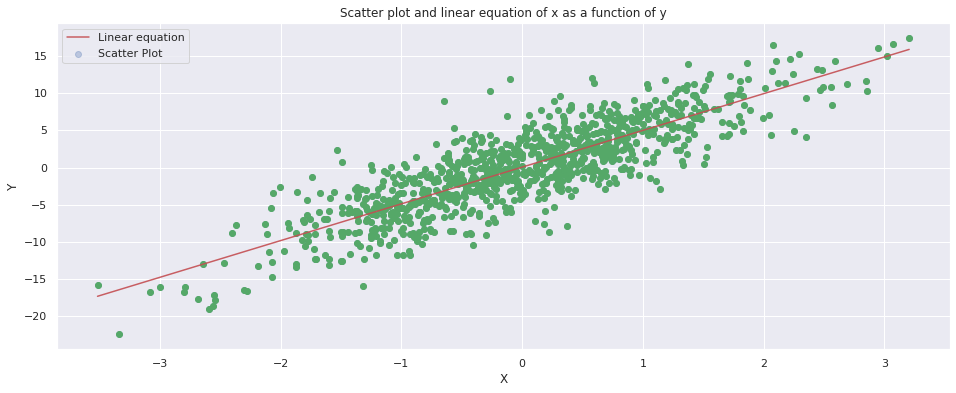

In [5]:
# scatter plot of X and y
from statsmodels import regression
import statsmodels.api as sm
def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

linreg(X, Y)
plt.scatter(X, Y)
plt.title('Scatter plot and linear equation of x as a function of y')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Linear equation', 'Scatter Plot']);

Between the covariance, the linear regression, and our knowledge of how $X$ and $Y$ are related, we can easily assess the relationship between our toy variables. With real data, there are two main complicating factors. The first is that we are examining significantly more relationships. The second is that we do not know any of their underlying relationships. These hindrances speak to the benefit of having accurate estimates of covariance matrices.

## The Covariance Matrix

As the number of assets we are curious about increases, so too do the dimensions of the covariance matrix that describes their relationships. If we take the covariance between $N$ assets, we will get out a $N \times N$ covariance matrix. This allows us to efficiently express the relationships between many arrays at once. As with the simple $2\times 2$ case, the $i$-th diagonal is the variance of the $i$-th asset and the values at $(i, j)$ and $(j, i)$ refer to the covariance between asset $i$ and asset $j$. We display this with the following notation:

$$ \Sigma = \left[\begin{matrix}
VAR(X_1) & COV(X_1, X_2) & \cdots & COV(X_1, X_N) \\
COV(X_2, X_0) & VAR(X_2) & \cdots & COV(X_2, X_N) \\
\vdots & \vdots & \ddots & \vdots \\
COV(X_N, X_1) & COV(X_N, X_2) & \cdots & VAR(X_N)
\end{matrix}\right] $$  

When trying to find the covariance of many assets, it quickly becomes apparent why the matrix notation is more favorable. 

In [6]:
from quantrocket.master import get_securities
from quantrocket import get_prices

# Four asset example of the covariance matrix.
symbol_list = ['SBUX', 'AAPL', 'GS', 'GILD']

securities = get_securities(symbols=symbol_list, vendors='usstock')

start_date = '2016-01-01'
end_date = '2016-02-01'

prices = get_prices("usstock-1d-bundle", data_frequency='daily', sids=securities.index.tolist(), start_date=start_date, end_date=end_date, fields='Close')
returns = prices.loc['Close'].pct_change()[1:]

sids_to_symbols = securities.Symbol.to_dict()
returns = returns.rename(columns=sids_to_symbols)

print('Covariance matrix:')
print(returns.cov())

Covariance matrix:
Sid       AAPL      GILD        GS      SBUX
Sid                                         
AAPL  0.000755  0.000243  0.000467  0.000336
GILD  0.000243  0.000544  0.000133  0.000078
GS    0.000467  0.000133  0.000539  0.000339
SBUX  0.000336  0.000078  0.000339  0.000451


## Why does all this matter?  

We measure the covariance of the assets in our portfolio to make sure we have an accurate picture of the risks involved in holding those assets together. We want to apportion our capital amongst these assets in such a way as to minimize our exposure to the risks associated with each individual asset and to neutralize exposure to systematic risk. This is done through the process of portfolio optimization. Portfolio optimization routines go through exactly this process, finding the appropriate weights for each asset given its risks. Mean-variance optimization, a staple of MPT, does exactly this. 

Estimating the covariance matrix becomes critical when using methods that rely on it, as we cannot know the true statistical relationships underlying our chosen assets. The stability and accuracy of these estimates are essential to getting stable weights that encapsulate our risks and intentions.

Unfortunately, the most obvious way to calculate a covariance matrix estimate, the sample covariance, is notoriously unstable. If we have fewer time observations of our assets than the number of assets ($T < N$), the estimate becomes especially unreliable. The extreme values react more strongly to changes, and as the extreme values of the covariance jump around, our optimizers are perturbed, giving us inconsistent weights. This is a problem when we are trying to make many independent bets on many assets to improve our risk exposures through diversification. Even if we have more time elements than assets that we are trading, we can run into issues, as the time component may span multiple regimes, giving us covariance matrices that are still inaccurate.

The solution in many cases is to use a robust formulation of the covariance matrix. If we can estimate a covariance matrix that still captures the relationships between assets and is simultaneously more stable, then we can have more faith in the output of our optimizers. A main way that we handle this is by using some form of a shrinkage estimator.

## Shrinkage Estimators

The concept of shrinkage stems from the need for stable covariance matrices. The basic way we "shrink" a matrix is to reduce the extreme values of the sample covariance matrix by pulling them closer to the center. Practically, we take a linear combination of the sample covariance covariance matrix a constant array representing the center.

Given a sample covariance matrix, $\textbf{S}$, the mean variance, $\mu$, and the shrinkage constant $\delta$, the shrunk estimated covariance is mathematically defined as:   

$$(1 - \delta)\textbf{S} + \delta\mu\textbf{1}$$  
 
We restrict $\delta$ such that $0 \leq \delta \leq 1$ making this a weighted average between the sample covariance and the mean variance matrix. The optimal value of $\delta$ has been tackled several times. For our purposes, we will use the formulation by Ledoit and Wolf.

## Ledoit-Wolf Estimator.

In [their paper](http://ledoit.net/honey.pdf), Ledoit and Wolf  proposed an optimal $\delta$: 

$$\hat\delta^* \max\{0, \min\{\frac{\hat\kappa}{T},1\}\}$$

$\hat\kappa$ has a mathematical formulation that is beyond the scope of this lecture, but you can find its definition in the paper.

The Ledoit-Wolf Estimator is the robust covariance estimate that uses this optimal $\hat\delta^*$ to shrink the sample covariance matrix. We can draw an implementation of it directly from `scikit-learn` for easy use.

In [7]:
# Getting the return data of assets. 
start = '2016-01-01'
end = '2016-02-01'

symbols = ['AAPL', 'MSFT', 'BRK.A', 'GE', 'FDX', 'SBUX']

securities = get_securities(symbols=symbols, vendors='usstock')

prices = get_prices("usstock-1d-bundle", data_frequency='daily', sids=securities.index.tolist(), start_date=start_date, end_date=end_date, fields='Close')
returns = prices.loc['Close'].pct_change()[1:]

sids_to_symbols = securities.Symbol.to_dict()
returns = returns.rename(columns=sids_to_symbols)

returns.head()

Sid,AAPL,BRK.A,FDX,GE,MSFT,SBUX
Date,,,,,,
2016-01-05,-0.025059,0.003591,0.008506,0.000977,0.004562,0.006699
2016-01-06,-0.019570,0.002107,-0.026823,-0.015940,-0.018165,-0.008861
2016-01-07,-0.042205,-0.009295,-0.043901,-0.042314,-0.034783,-0.024784
2016-01-08,0.005288,-0.008590,0.000892,-0.017950,0.003067,-0.001044
2016-01-11,0.016192,-0.004332,-0.012917,0.004569,-0.000573,0.021011


Here we calculate the in-sample Ledoit-Wolf estimator.

In [8]:
in_sample_lw = covariance.ledoit_wolf(returns)[0]
print(in_sample_lw)

[[0.00066814 0.00014687 0.00028375 0.00020436 0.00041898 0.00026362]
 [0.00014687 0.00020807 0.00017612 0.00012173 0.00016557 0.00015173]
 [0.00028375 0.00017612 0.00046565 0.00021758 0.00034163 0.00024734]
 [0.00020436 0.00012173 0.00021758 0.0003382  0.00023617 0.00023588]
 [0.00041898 0.00016557 0.00034163 0.00023617 0.00051674 0.0002286 ]
 [0.00026362 0.00015173 0.00024734 0.00023588 0.0002286  0.00042869]]


### Calculating Errors

We can quantify the difference between the in and out-of-sample estimates by taking the absolute difference element-by-element for the two matrices. We represent this mathematically as: 

$$ \frac{1}{n} \sum_{i=1}^{n} |a_i - b_i| $$

First, we calculate the out-of-sample estimate and then we compare.

In [9]:
oos_start = '2016-02-01'
oos_end = '2016-03-01'

oos_prices = get_prices("usstock-1d-bundle", data_frequency='daily', sids=securities.index.tolist(), start_date=oos_start, end_date=oos_end, fields='Close')
oos_returns = oos_prices.loc['Close'].pct_change()[1:]
oos_returns = oos_returns.rename(columns=sids_to_symbols)
out_sample_lw = covariance.ledoit_wolf(oos_returns)[0]

lw_errors = sum(abs(np.subtract(in_sample_lw, out_sample_lw)))
print("Average Ledoit-Wolf error:", np.mean(lw_errors))

Average Ledoit-Wolf error: 0.0005643540148306282


### Comparing to Sample Matrix

We can check how much of an improvement this is by comparing the errors with the erros of the sample covariance.

In [10]:
sample_errors = sum(abs(np.subtract(returns.cov().values, oos_returns.cov().values)))
print('Average sample covariance error:', np.mean(sample_errors))

Average sample covariance error: 0.000677493299285417


In [11]:
print('Error improvement of LW over sample: {0:.2f}%'.format((np.mean(sample_errors/lw_errors)-1)*100))

Error improvement of LW over sample: 19.25%


We can see that the improvement of Ledoit-Wolf over the sample covariance is pretty solid. This translates into decreased volatility and turnover rate in our portfolio, and thus increased returns when using the shrunk covariance matrix. 

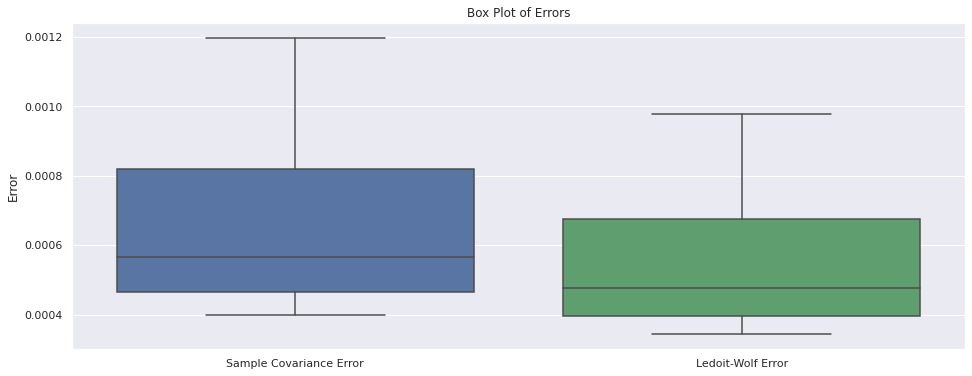

In [12]:
sns.boxplot(
    data = pd.DataFrame({
        'Sample Covariance Error': sample_errors,
        'Ledoit-Wolf Error': lw_errors
    })
)
plt.title('Box Plot of Errors')
plt.ylabel('Error');

### Adding More Assets

Now we bring this to more assets over a longer time period. Let's see how the errors change over a series of months.

In [13]:
start_date = '2016-01-01'
end_date = '2017-06-01'

symbols = [
    'SPY', 'XLF', 'XLE', 'XLU','XLK', 'XLI', 'XLB', 'GE', 'GS', 'BRK.A', 'JPM', 'AAPL', 'MMM', 'BA',
    'CSCO','KO', 'DIS','DD', 'XOM', 'INTC', 'IBM', 'NKE', 'MSFT', 'PG', 'UTX', 'HD', 'MCD', 'CVX', 
    'AXP','JNJ', 'MRK', 'CAT', 'PFE', 'TRV', 'UNH', 'WMT', 'VZ', 'QQQ', 'BAC', 'F', 'C', 'CMCSA',
    'MS', 'ORCL', 'PEP', 'HON', 'GILD', 'LMT', 'UPS', 'HP', 'FDX', 'GD', 'SBUX'
]

securities = get_securities(symbols=symbols, vendors='usstock')

prices = get_prices("usstock-1d-bundle", data_frequency='daily', sids=securities.index.tolist(), start_date=start_date, end_date=end_date, fields='Close')
returns = prices.loc['Close'].pct_change()[1:]

sids_to_symbols = securities.Symbol.to_dict()
returns = returns.rename(columns=sids_to_symbols)

dates = returns.resample('M').first().index

Here we calculate our different covariance estimates.

In [14]:
sample_covs = []
lw_covs = []

for i in range(1, len(dates)):
    sample_cov = returns[dates[i-1]:dates[i]].cov().values
    sample_covs.append(sample_cov)
    
    lw_cov = covariance.ledoit_wolf(returns[dates[i-1]:dates[i]])[0]
    lw_covs.append(lw_cov)      

Here we calculate the error for each time period.

In [15]:
lw_diffs = []
for pair in zip(lw_covs[:-1], lw_covs[1:]):
    diff = np.mean(np.sum(np.abs(pair[0] - pair[1])))
    lw_diffs.append(diff)
    
sample_diffs = []
for pair in zip(sample_covs[:-1], sample_covs[1:]):
    diff = np.mean(np.sum(np.abs(pair[0] - pair[1])))
    sample_diffs.append(diff)

And here we plot the errors over time!

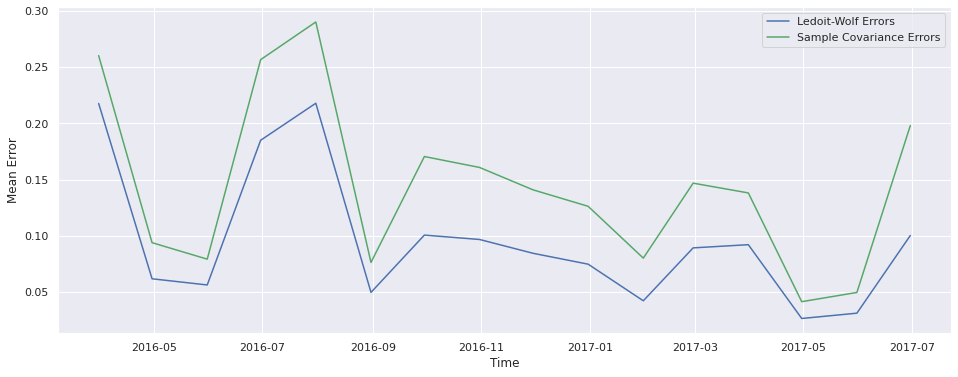

In [16]:
plt.plot(dates[2:], lw_diffs)
plt.plot(dates[2:], sample_diffs)
plt.xlabel('Time')
plt.ylabel('Mean Error')
plt.legend(['Ledoit-Wolf Errors', 'Sample Covariance Errors']);

We can see that the mean errors of Ledoit-Wolf are lower than those of the sample covariance matrix. This shows us that the sample sample covariance matrix is less robust. This example only used 50 assets, but as we add more, the Ledoit-Wolf estimator would likely perform even better as the number of assets outpaces the number of observations.

---

**Next Lecture:** [Introduction to Volume, Slippage, and Liquidity](Lecture27-Introduction-to-Volume-Slippage-and-Liquidity.ipynb)

[Back to Introduction](Introduction.ipynb) 

---

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by QuantRocket LLC ("QuantRocket"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, the authors have not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information believed to be reliable at the time of publication. QuantRocket makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*